# Build US BLM solar constraint suitablity layers for GRIDCERF


The following code was used to build the US BLM Renewable suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.57931/2281697.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


### Data Relevant to Solar Technologies

- **Title**:  Maps of Areas Identified in the 2012 Solar PEIS ROD
- **Description from Source**: The geographic information system (GIS) data files available for download below contain key spatial data for land use allocations and exclusions identified through the 2012 Solar PEIS ROD in GIS shapefile format. 
- **Source URL**:  https://blmsolar.anl.gov/maps/solar-peis/#exclusions
- **Date Accessed**:  09/26/23
- **Citation**
> US Bureau of Land Management, 2012. Maps of Areas Identified in the 2012 Solar PEIS ROD, https://blmsolar.anl.gov/maps/solar-peis/#exclusions
- **Application**: According to US BLM "As described in the 2012 Solar PEIS ROD, all utility-scale solar energy development must be in conformance with the exclusions adopted through the Solar PEIS ROD and the associated land use plan amendments." Therefore, all excluded areas provided in the downloaded shapefiles are excluded from siting for solar technologies (including both PV and CSP). Information available includes excluded areas for California, Colorado, Utah, Nevada, New Mexico, and Arizona. Each of these are used to create a suitability layers for each category. This data was created for US BLM by Argonne National Laboratory and is part of the Programmatic Environmental Impact Statement for Solar Energy Development in Six Southwestern States (Solar PEIS). The map on this webpage shows which areas are excluded from siting: https://blmsolar.anl.gov/.

    Specific 2012 Solar PEIS Exclusion Categories were defined by the BLM, additional updates were added in two subsequent years. This exclusion layer is built on these considerations.

  The table below outlines the specific layers created for the GRIDCERF dataset to meet solar exclusions listed in the reference above. Note that there are multiple layers that apply to solar technologies that are already included in the GRIDCERF database (e.g., conservation lands) and are not recreated here. 

|Layer Description|State|Source Shapefile|GRIDCERF Raster name|
|----------------|-----|----------|------------------|
|Recreational Facilities|AZ|rec_sites_6.shp |gricerf_blm_az_recreational_facilities.tif|
|Special Recreation Management Areas Excluding Nevada and Yuma East|AZ|SRMA_6.shp |gridcerf_blm_srma_exclude_nevada_yuma_east.tif|
||CA|SRMA_6.shp ||
||CO|SRMA_6.shp ||
||NM|SRMA_6.shp ||
||UT|SRMA_6.shp ||
|New Exclusions Between Supplement and Final Solar PEIS |AZ|az_exclude_32.shp |gridcerf_blm_peis_supplemental_exclusions.tif|
||CA|CA_exclude_32.shp||
||NV|NV_exclude_32.shp||
||NM|NPS_exclude_32.shp||
||UT|UT_exclude_32.shp ||
|Previously Proposed SEZ Lands Excluded |AZ|sez_non_dev_29.shp|gridcerf_blm_solar_energy_zone_exclusions.tif|
||CA|iron_mtn_29.shp||
||CA|CA_exclude_29.shp||
||CA|sez_non_dev_29.shp||
||CO|sez_non_dev_29.shp||
||CO|CO_exclude_32_2.shp||
||CO|CO_exclude_32||
||CO|columbine_fo_32||
||CO|gfo_exclude_32||
||CO|mesa_verde_32||
||NV|sez_non_dev_29 ||
||UT|sez_non_dev_29.shp||
|California Desert Wildlife Management Areas|CA|dwma_3.shp |gridcerf_ca_desert_wildlife_management_areas.tif|
|Flat Tailed Horned Lizard Habitat |CA|flat_tailed_horned_lizard_7.shp|gridcerf_blm_flat_tailed_horned_lizard_habitat.tif|
|Fringe Toed Lizard Habitat|CA|fringe_toed_lizard_7.shp|gridcerf_blm_fringe_toed_lizard_habitat.tif|
|Mohave Ground Squirrel Habitat |CA|Mohave_gr_squirrel_7.shp|gridcerf_blm_mojave_ground_squirrel_habitat.tif|
|Sage-Grouse Habitat |CA|sage_grouse_7.shp |gridcerf_blm_sage_grouse_habitat.tif|
||CO|sage_grouse_7.shp ||
||CA|sage_grouse_8.shp ||
||CO|sage_grouse_8.shp ||
||UT|sage_grouse_8.shp ||
|Ivanpah Valley Exclusions|CA|ivanpah_valley_13.shp|gridcerf_blm_ivanpah_valley_exclusions.tif|
|Garden Valley Exclusions|NV|garden_valley_coal_valley_14.shp||
|Ivanpah Valley Exclusions|NV|ivanpah_valley_13.shp||
|Nevada Instant Study Areas|NV|instant_study_21.shp|gridcerf_blm_nv_instant_study_areas.tif|


### 1.3 Import modules


In [40]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features
from rasterio.plot import show

## 2. Configuration


In [7]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'blm_renewable_exclusions')

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF technology_specific data directory
common_dir = os.path.join(gridcerf_dir, "common")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template siting mask raster
siting_mask_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile locations
# solar
solar_source_dir = os.path.join(source_dir, 'solar_exclusions')
az_solar_dir = os.path.join(solar_source_dir, 'Arizona_Shapefiles', 'az_mapper_exclusions')
ca_solar_dir = os.path.join(solar_source_dir, 'California_Shapefiles', 'ca_mapper_exclusions')
ut_solar_dir = os.path.join(solar_source_dir, 'Utah_Shapefiles', 'ut_mapper_exclusions')
nv_solar_dir = os.path.join(solar_source_dir, 'Nevada_Shapefiles', 'nv_mapper_exclusions')
nm_solar_dir = os.path.join(solar_source_dir, 'New_Mexico_Shapefiles', 'nm_mapper_exclusions')
co_solar_dir = os.path.join(solar_source_dir, 'Colorado_Shapefiles', 'co_mapper_exclusions')


# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


## 3. Functions

In [23]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


## 4. Generate suitability rasters

In [46]:
# dictionary of output rasters and their associated input files
solar_compile_dict={
    'gridcerf_blm_az_recreational_facilities.tif':[
        os.path.join(az_solar_dir, 'rec_sites_6.shp')],
    'gridcerf_blm_srma_exclude_nevada_yuma_east.tif':[
        os.path.join(az_solar_dir, 'SRMA_6.shp'),
        os.path.join(ca_solar_dir, 'SRMA_6.shp'),
        os.path.join(co_solar_dir, 'SRMA_6.shp'),
        os.path.join(nm_solar_dir, 'SRMA_6.shp'),
        os.path.join(ut_solar_dir, 'SRMA_6.shp')],
    'gridcerf_blm_peis_supplemental_exclusions.tif':[
        os.path.join(az_solar_dir, 'az_exclude_32.shp'),
        os.path.join(ca_solar_dir, 'CA_exclude_32.shp'),
        os.path.join(nv_solar_dir, 'NV_exclude_32.shp'),
        os.path.join(nm_solar_dir, 'NPS_exclude_32.shp'),
        os.path.join(ut_solar_dir, 'UT_exclude_32.shp')],
    'gridcerf_blm_solar_energy_zone_exclusions.tif':[
        os.path.join(az_solar_dir, 'sez_non_dev_29.shp'),
        os.path.join(ca_solar_dir, 'iron_mtn_29.shp'),        
        os.path.join(ca_solar_dir, 'CA_exclude_29.shp'),
        os.path.join(ca_solar_dir, 'sez_non_dev_29.shp'),
        os.path.join(co_solar_dir, 'sez_non_dev_29.shp' ),        
        os.path.join(co_solar_dir, 'CO_exclude_32_2.shp'),        
        os.path.join(co_solar_dir, 'CO_exclude_32.shp'),        
        os.path.join(co_solar_dir, 'columbine_fo_32.shp'),         
        os.path.join(co_solar_dir, 'gfo_exclude_32.shp'),        
        os.path.join(co_solar_dir, 'mesa_verde_32.shp'),        
        os.path.join(nv_solar_dir, 'sez_non_dev_29.shp'),
        os.path.join(ut_solar_dir, 'sez_non_dev_29.shp')],
    'gridcerf_blm_ca_desert_wildlife_management_areas.tif':[
        os.path.join(ca_solar_dir, 'dwma_3.shp')],
    'gridcerf_blm_flat_tailed_horned_lizard_habitat.tif':[
        os.path.join(ca_solar_dir, 'flat_tailed_horned_lizard_7.shp')],
    'gridcerf_blm_fringe_toed_lizard_habitat.tif':[
        os.path.join(ca_solar_dir, 'fringe_toed_lizard_7.shp')],
    'gridcerf_blm_mojave_ground_squirrel_habitat.tif':[
        os.path.join(ca_solar_dir, 'Mohave_gr_squirrel_7.shp')],
    'gridcerf_blm_sage_grouse_habitat.tif':[
        os.path.join(ca_solar_dir, 'sage_grouse_8.shp'),    
        os.path.join(nv_solar_dir, 'sage_grouse_7.shp'),
        os.path.join(nv_solar_dir, 'sage_grouse_8.shp'),   
        os.path.join(ut_solar_dir, 'sage_grouse_8.shp'), ],
    'gridcerf_blm_ivanpah_valley_exclusions.tif':[
        os.path.join(ca_solar_dir, 'ivanpah_valley_13.shp'),
        os.path.join(nv_solar_dir, 'ivanpah_valley_13.shp')],
    'gridcerf_blm_garden_coal_valley_exclusions.tif':[
        os.path.join(nv_solar_dir, 'ivanpah_valley_13.shp')],
    'gridcerf_blm_nv_instant_study_areas.tif':[
        os.path.join(nv_solar_dir, 'instant_study_21.shp')]}


gridcerf_blm_az_recreational_facilities.tif


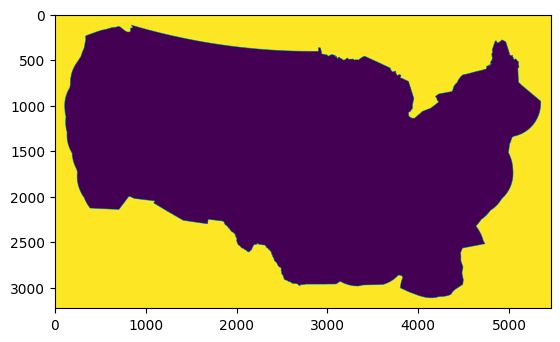

gridcerf_blm_srma_exclude_nevada_yuma_east.tif


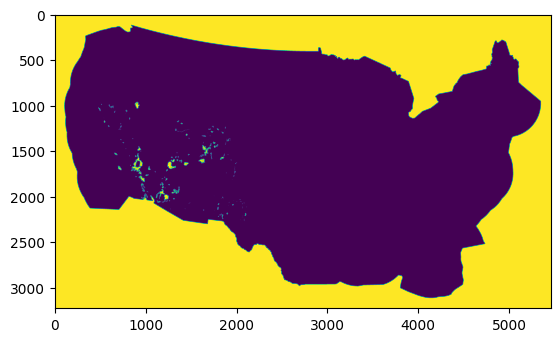

gridcerf_blm_peis_supplemental_exclusions.tif


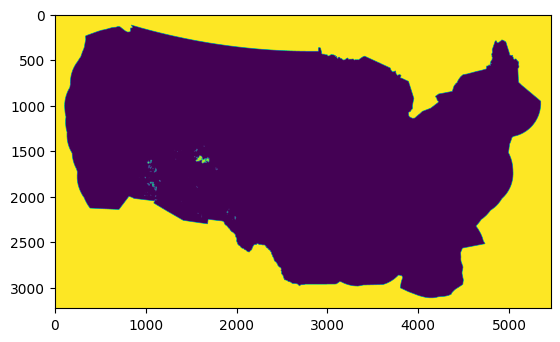

gridcerf_blm_solar_energy_zone_exclusions.tif


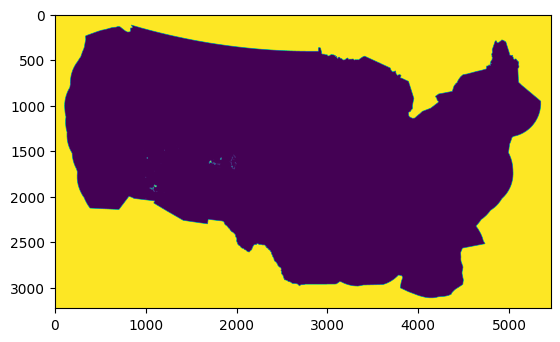

gridcerf_blm_ca_desert_wildlife_management_areas.tif


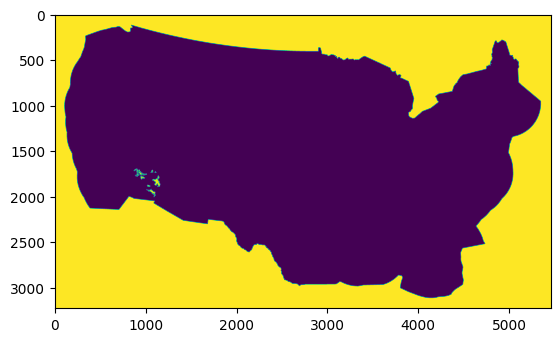

gridcerf_blm_flat_tailed_horned_lizard_habitat.tif


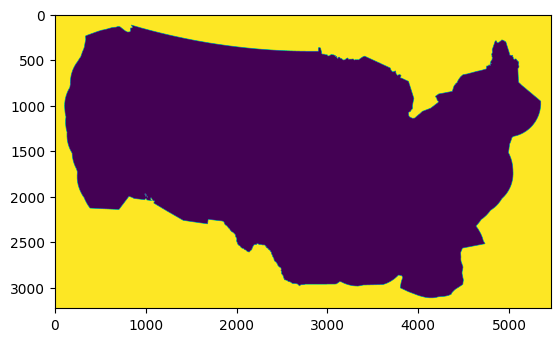

gridcerf_blm_fringe_toed_lizard_habitat.tif


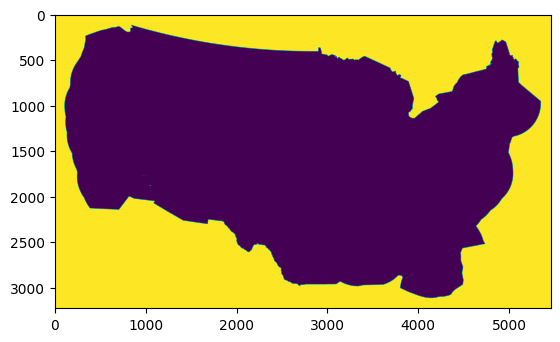

gridcerf_blm_mojave_ground_squirrel_habitat.tif


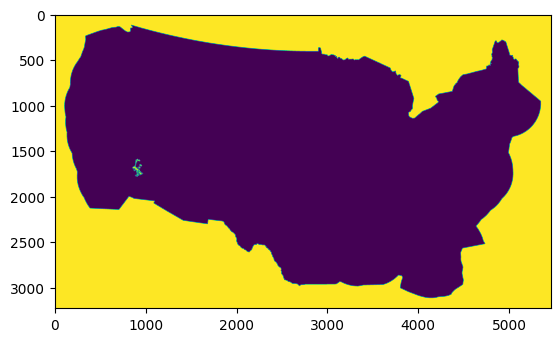

gridcerf_blm_sage_grouse_habitat.tif


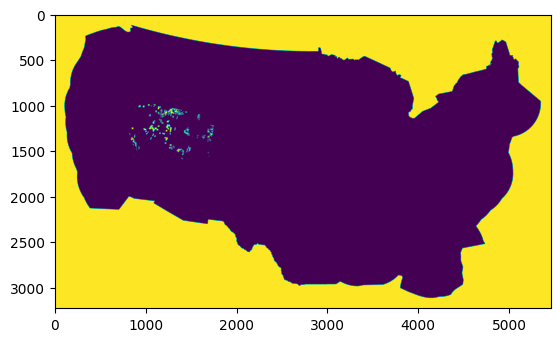

gridcerf_blm_ivanpah_valley_exclusions.tif


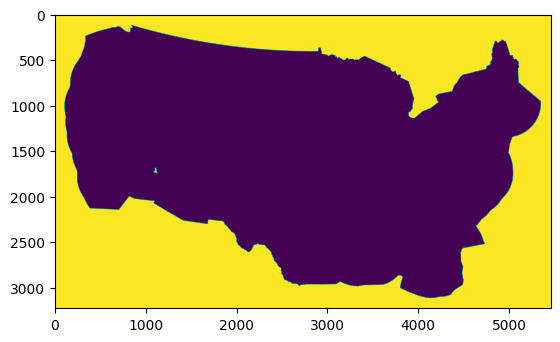

gridcerf_blm_garden_coal_valley_exclusions.tif


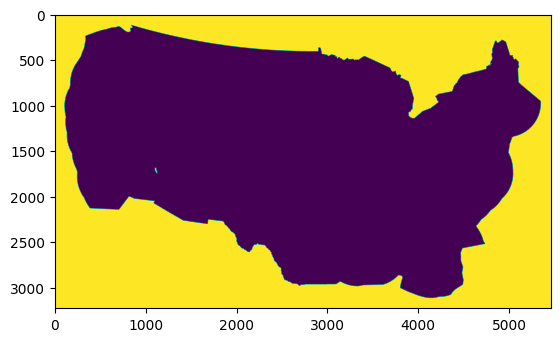

gridcerf_blm_nv_instant_study_areas.tif


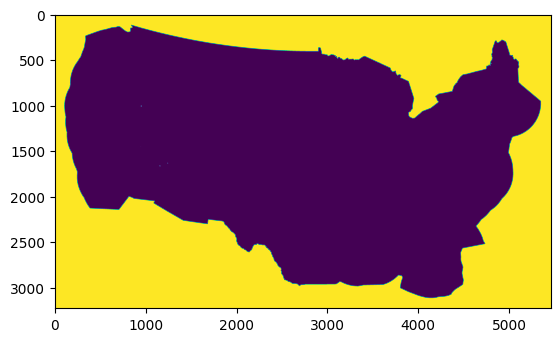

In [47]:
crs = 'ESRI:102003'
for raster in solar_compile_dict:
    print(raster)
    compile_list = solar_compile_dict[raster]
    for file in compile_list:
        gdf = gpd.read_file(file)
        gdf.to_crs(crs, inplace=True)
        
        if compile_list[0] == file:
            output_shp = gdf
        else:
            output_shp = pd.concat([output_shp, gdf])

    output_shp['value'] = 1

    output_raster = os.path.join(technology_specific_dir, raster)
    
    # generate raster
    vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=siting_mask_raster,
                 gdf=output_shp, 
                 value_field="value",
                 output_raster=output_raster)
    show(rasterio.open(output_raster).read(1))